In [5]:
setwd("/home/pasoneto/Documents/github/doc_suomi/code")
library("keras")
source("utils.R")
source("data_cook.R")
library(randomForest)
library("splines")
library("mltools")
setwd("/home/pasoneto/Documents/github/doc_suomi/data")

In [576]:
#### data prep
dt = dissim_matrix %>% group_by(album_id) %>%
            mutate(position = segment(track_number)) %>%
            group_by(album_id, position) %>%
            mutate(track_number = seq(1, NROW(track_number), 1), 
                   position = as.factor(position)) %>% ungroup() %>%
            mutate(valence = minmax(valence), energy = minmax(energy), 
                   loudness = minmax(loudness), tempo = minmax(tempo), 
                   track_number = minmax(track_number)) %>% ungroup() %>% group_by(album_id) %>%
            mutate(valence_next = shift(valence, -1), energy_next = shift(energy, -1), 
                   loudness_next = shift(loudness, -1), tempo_next = shift(tempo, -1)) %>%
            ungroup() %>% na.omit() %>%
            mutate(position = as.factor(position)) %>%
            fastDummies::dummy_cols(select_columns = "position", remove_selected_columns = TRUE)

#Train test split
treino = treino_teste(dt)$train
teste = treino_teste(dt)$test

treino = apply(as.matrix(treino), 2, as.numeric)
teste = apply(as.matrix(teste), 2, as.numeric)

Warning message in apply(as.matrix(treino), 2, as.numeric):
“NAs introduced by coercion”
Warning message in apply(as.matrix(teste), 2, as.numeric):
“NAs introduced by coercion”


# Track orders - regression approach

## Structure

Predictors:

- Valence of track $i$ (continuous)
- Energy of track $i$ (continuous)
- Loudness of track $i$ (continuous)
- Tempo of track $i$ (continuous)
- Number of track $i$ (from 1 to 16)
- Position $i$ (sections from 1 to 3)
- Interactions between valence, energy, loudness and tempo

Dependent variable:

- Valence/energy/loudness/tempo  of track $i+1$ (continuous)

## Models

I attempted to predict the value of track in position $i+1$ given the features of track in position $i$. In this first attempt, I used 1) splines regression; 2) random forrest and 3) LSTM. All models were trained in 75% of the albums, and tested on both train and test splits.

## Model diagnostics

Detailed diagnostics and parameters of each model are omited for brevity. Here, for each regression attempt, I report: 1) R² (from training dataset) and RMSE (from test dataset). I also provide some visualizations of true vs predicted data (by album).

### R²

The Random Forest algorithm is, by far, the best fit to our data, with 20 to 30 percent of variance explained. This is consistent with the previous (classification) model, which was able to guess, with ~32% accuracy, if a track pertained to the 1st, 2nd, 3d or 4th section of the album.

Splines regression was very close to baseline (3 knots and 4 degree polynomials). LSTM performed badly, which might be due to poor choices of parameters -on my end. The negative R2 values indicate that our model fit actually increases error in comparison with the zero rule (predicting the mean).

In [501]:
# Splines
valence_spline   = lm(valence_next~bs(valence, knots = 3)+bs(energy, knots = 3)+bs(loudness, knots = 3)+bs(tempo, knots = 3)+bs(track_number, knots = 3)+position_1st+position_2nd+position_3d, data = dt)
energy_spline    = lm(energy_next~bs(valence, knots = 3)+bs(energy, knots = 3)+bs(loudness, knots = 3)+bs(tempo, knots = 3)+bs(track_number, knots = 3)+position_1st+position_2nd+position_3d, data = dt)
loudness_spline  = lm(loudness_next~bs(valence, knots = 3)+bs(energy, knots = 3)+bs(loudness, knots = 3)+bs(tempo, knots = 3)+bs(track_number, knots = 3)+position_1st+position_2nd+position_3d, data = dt)
tempo_spline     = lm(tempo_next~bs(valence, knots = 3)+bs(energy, knots = 3)+bs(loudness, knots = 3)+bs(tempo, knots = 3)+bs(track_number, knots = 3)+position_1st+position_2nd+position_3d, data = dt)

In [502]:
# Random Forest
valence_rf  = randomForest(valence_next ~ valence+energy+loudness+tempo+track_number+position_1st+position_2nd+position_3d, importance = TRUE, data = dt)
energy_rf   = randomForest(energy_next ~ valence+energy+loudness+tempo+track_number+position_1st+position_2nd+position_3d, importance = TRUE, data = dt)
loudness_rf = randomForest(loudness_next ~ valence+energy+loudness+tempo+track_number+position_1st+position_2nd+position_3d, importance = TRUE, data = dt)
tempo_rf    = randomForest(tempo_next ~ valence+energy+loudness+tempo+track_number+position_1st+position_2nd+position_3d, importance = TRUE, data = dt)

In [513]:
# LSTM
model = model_setup()
pred_vars = c("valence", "energy", "loudness", "tempo", "track_number", "position_1st", "position_2nd", "position_3d")

valence_lstm = lstm(var_interest = "valence_next", var_pred = pred_vars, model = model, treino = treino, teste = teste)
energy_lstm = lstm(var_interest = "energy_next", var_pred = pred_vars, model = model, treino = treino, teste = teste)
loudness_lstm = lstm(var_interest = "loudness_next", var_pred = pred_vars, model = model, treino = treino, teste = teste)
tempo_lstm = lstm(var_interest = "tempo_next", var_pred = pred_vars, model = model, treino = treino, teste = teste)

In [669]:
# R2 Evals
R2_spline = c(r2(var_interest = "valence_next", pred_vars = pred_vars,  model = valence_spline,  data = data.frame(treino)),
              r2(var_interest = "energy_next", pred_vars = pred_vars,   model = energy_spline,   data = data.frame(treino)),
              r2(var_interest = "loudness_next", pred_vars = pred_vars, model = loudness_spline, data = data.frame(treino)),
              r2(var_interest = "tempo_next", pred_vars = pred_vars,    model = tempo_spline,    data = data.frame(treino))
             )

R2_rf = c(r2(var_interest = "valence_next",  pred_vars = pred_vars, model = valence_rf,  data = data.frame(treino)),
          r2(var_interest = "energy_next",   pred_vars = pred_vars, model = energy_rf,   data = data.frame(treino)),
          r2(var_interest = "loudness_next", pred_vars = pred_vars, model = loudness_rf, data = data.frame(treino)),
          r2(var_interest = "tempo_next",    pred_vars = pred_vars, model = tempo_rf,    data = data.frame(treino))
         )

R2_lstm = c(r2(var_interest = "valence_next",  pred_vars = pred_vars, model = valence_lstm,  data = treino),
            r2(var_interest = "energy_next",   pred_vars = pred_vars, model = energy_lstm,   data = treino),
            r2(var_interest = "loudness_next", pred_vars = pred_vars, model = loudness_lstm, data = treino),
            r2(var_interest = "tempo_next",    pred_vars = pred_vars, model = tempo_lstm,    data = treino)
         )


#R2 visualizations
oa = data.frame( R2 = c(R2_spline, R2_rf, R2_lstm),
            dependent_vars = rep(c("valence", "energy", "loudness", "tempo"), 3),
            algorithm = c(rep(c("splines"), 4), rep(c("randomForest"), 4), rep(c("lstm"), 4)))

Warning message in predict.lm(model, data[, pred_vars]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, data[, pred_vars]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, data[, pred_vars]):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, data[, pred_vars]):
“prediction from a rank-deficient fit may be misleading”


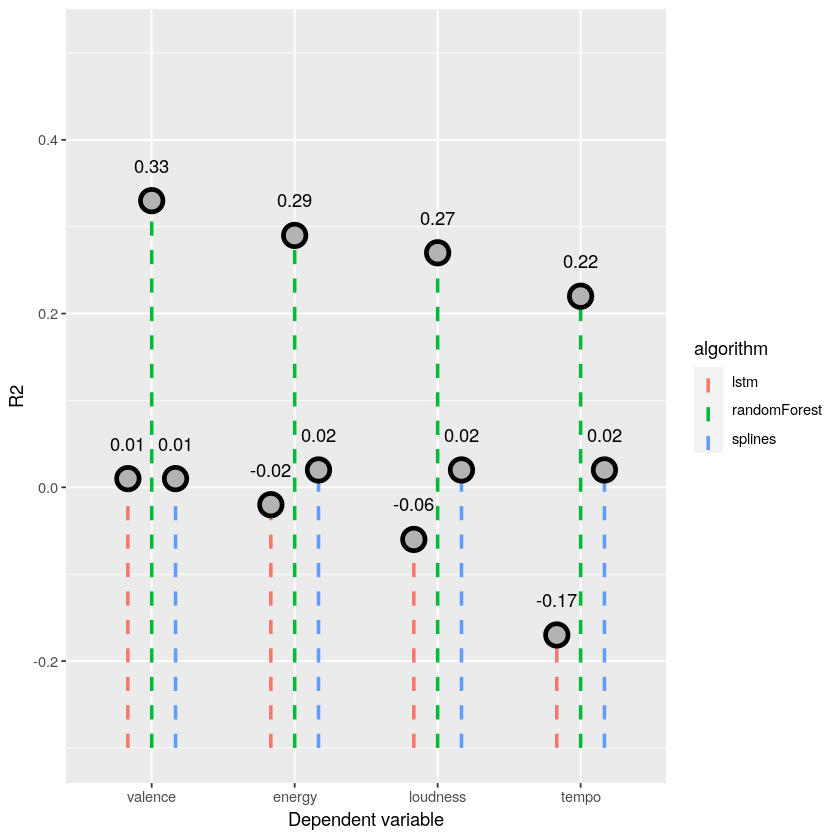

In [7]:
#R2 visualizations
oa = data.frame( R2 = c(0.01, 0.02, 0.02, 0.02, 0.33, 0.29, 0.27, 0.22, 0.01, -0.02, -0.06, -0.17),
            dependent_vars = rep(c("valence", "energy", "loudness", "tempo"), 3),
            algorithm = c(rep(c("splines"), 4), rep(c("randomForest"), 4), rep(c("lstm"), 4)))

oa %>% ggplot(aes(x = reorder(dependent_vars, -R2), y = R2, color = algorithm, group = algorithm))+
            geom_linerange(aes(ymin = -0.3, ymax = R2), size = 1, linetype = "dashed", position=position_dodge(width = .5)) +
            geom_point(size = 5, shape = 21, colour = "black", fill = "gray70", stroke = 2, position=position_dodge(width = .5)) +
            geom_text(colour = "black", aes(label = round(R2, digits = 2)), hjust = 0.5, vjust = -2, position=position_dodge(width = .5))+ylim(c(-0.3, 0.51))+
            xlab("Dependent variable")+ylab("R2")

### RMSE

Here I provide a baseline RMSE by predicting the feature in position $i+1$ as the mean of that feature's distribution. 

This baseline shows that, with the exception of the Random Forest algorithm, all models perform at baseline.

The next figure shows some predictions on randomly picked albums. Here it is clear that the Random Forest is really getting somewhere. It makes some right decisions towards increases/decreases of the next feature, but its magnitude is just very far from the actual data.

In [693]:
#Predicting album features
album_pred <- function(data, var_interest, pred_vars, model1, model2, model3){
                       spline        = predict(model1, data.frame(data[, pred_vars]))
                       lstm          = predict(model2, data[, pred_vars])
                       rforest       = predict(model3, data[, pred_vars])
                       true          = data[, var_interest]
                       zerorule      = rep(zrule(data, var_interest), 16)
                       
                       rmse_spline   = Metrics::rmse(spline, true)
                       rmse_lstm     = Metrics::rmse(lstm, true)
                       rmse_rforest  = Metrics::rmse(rforest, true)
                       rmse0         = Metrics::rmse(zerorule, true)

                        result = data.frame(
                           algorithm     = c("spline", "lstm", "rforest", "zerorule"),
                           rmse         = c(rmse_spline, rmse_lstm, rmse_rforest, rmse0),
                           dependent_variable = rep(var_interest, 4)
                       )    
    return(result)
}

v = album_pred(treino, "valence_next", pred_vars, valence_spline, valence_lstm, valence_rf)
e = album_pred(treino, "energy_next", pred_vars, energy_spline, energy_lstm, energy_rf)
l = album_pred(treino, "loudness_next", pred_vars, loudness_spline, loudness_lstm, loudness_rf)
t = album_pred(treino, "tempo_next", pred_vars, tempo_spline, tempo_lstm, tempo_rf)

rmse_final = dplyr::bind_rows(v, e, l, t)

Warning message in predict.lm(model1, data.frame(data[, pred_vars])):
“prediction from a rank-deficient fit may be misleading”
Warning message in actual - predicted:
“longer object length is not a multiple of shorter object length”
Warning message in predict.lm(model1, data.frame(data[, pred_vars])):
“prediction from a rank-deficient fit may be misleading”
Warning message in actual - predicted:
“longer object length is not a multiple of shorter object length”
Warning message in predict.lm(model1, data.frame(data[, pred_vars])):
“prediction from a rank-deficient fit may be misleading”
Warning message in actual - predicted:
“longer object length is not a multiple of shorter object length”
Warning message in predict.lm(model1, data.frame(data[, pred_vars])):
“prediction from a rank-deficient fit may be misleading”
Warning message in actual - predicted:
“longer object length is not a multiple of shorter object length”


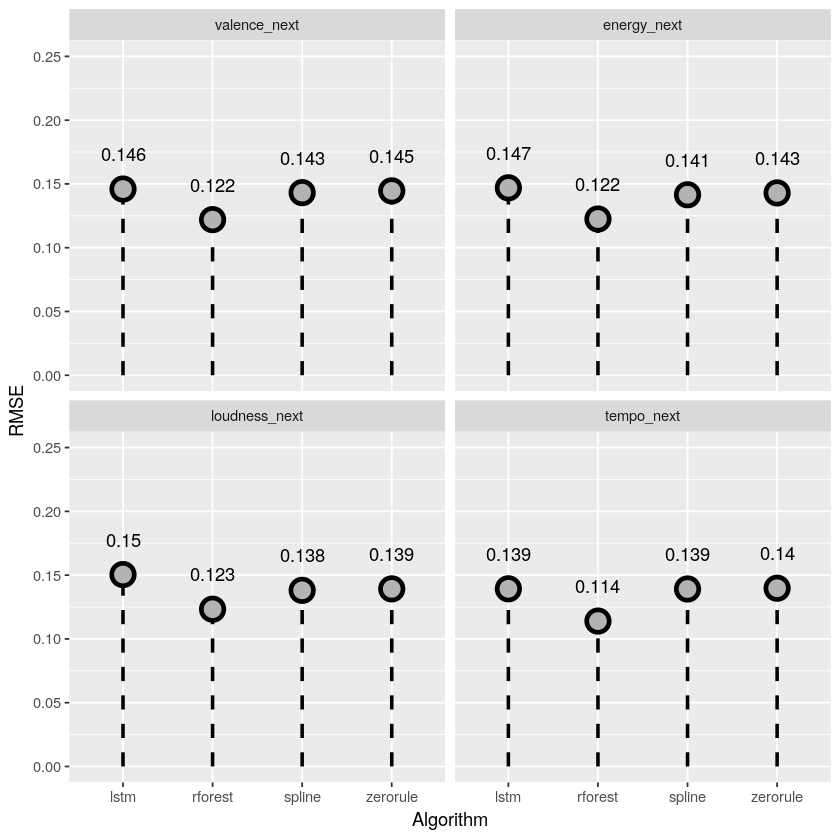

In [697]:
ggplot(rmse_final, aes(x = algorithm, y = rmse))+
    facet_wrap(~dependent_variable)+
    geom_linerange(aes(ymin = 0, ymax = rmse), size = 1, linetype = "dashed", position=position_dodge(width = .2)) +
    geom_point(size = 5, shape = 21, colour = "black", fill = "gray70", stroke = 2, position=position_dodge(width = .2)) +
    geom_text(colour = "black", aes(label = round(rmse, digits = 3)), hjust = 0.5, vjust = -2, position=position_dodge(width = .2))+ylim(c(0, 0.25))+
    xlab("Algorithm")+ylab("RMSE")

In [706]:
#Predicting album features
album_pred <- function(data, var_interest, pred_vars, model1, model2, model3){
                       album         = album_random()
                       spline        = predict(model1, data.frame(data[, pred_vars][album, ]))
                       lstm          = predict(model2, data[, pred_vars][album, ])
                       rforest       = predict(model3, data[, pred_vars][album, ])
                       true          = data[, var_interest][album]
                       zerorule      = rep(zrule(data, var_interest), 16)
                       track_number  = rep(seq(1, 16, 1), 4)
    
                       rmse_spline   = Metrics::rmse(spline, true)
                       rmse_lstm     = Metrics::rmse(lstm, true)
                       rmse_rforest  = Metrics::rmse(rforest, true)
                       rmse0         = Metrics::rmse(zerorule, true)

                        result = data.frame(
                           algorithm     = c(rep("spline", 16), rep("lstm", 16), rep("rforest", 16), rep("true", 16)),
                           value         = c(spline, lstm, rforest, true),
                           track_number  = track_number
                       )                       
                       
                       return(ggplot(result, aes(x = track_number, y = value, group = algorithm, color = algorithm)) +
                           geom_line()+ ylab("Feature value") + xlab("Track Number")+ geom_point()+
                           ggtitle(paste(var_interest, '\n',
                                         "RMSE spline: ",   rmse_spline, '\n' ,
                                         "RMSE lstm: ",     rmse_lstm, '\n',
                                         "RMSE rForest: ",  rmse_rforest, '\n',
                                         "RMSE zerorule: ", rmse0 )))

}

va = album_pred(treino, "valence_next", pred_vars, valence_spline, valence_lstm, valence_rf)
en = album_pred(treino, "energy_next", pred_vars, energy_spline, energy_lstm, energy_rf)
lo = album_pred(treino, "loudness_next", pred_vars, loudness_spline, loudness_lstm, loudness_rf)
te = album_pred(treino, "tempo_next", pred_vars, tempo_spline, tempo_lstm, tempo_rf)

Warning message in predict.lm(model1, data.frame(data[, pred_vars][album, ])):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model1, data.frame(data[, pred_vars][album, ])):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model1, data.frame(data[, pred_vars][album, ])):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model1, data.frame(data[, pred_vars][album, ])):
“prediction from a rank-deficient fit may be misleading”


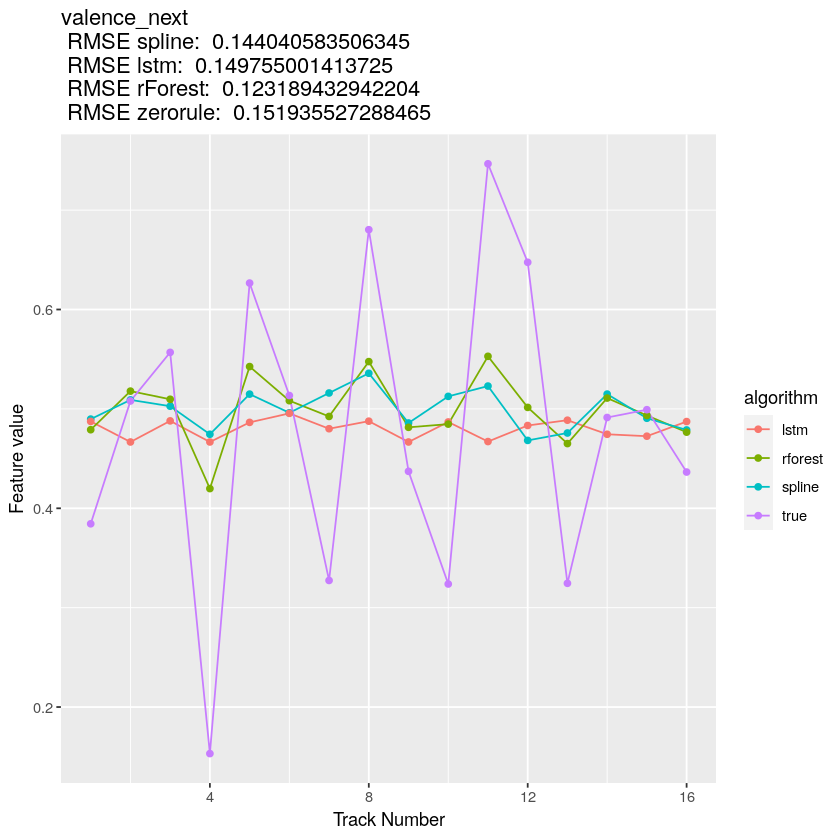

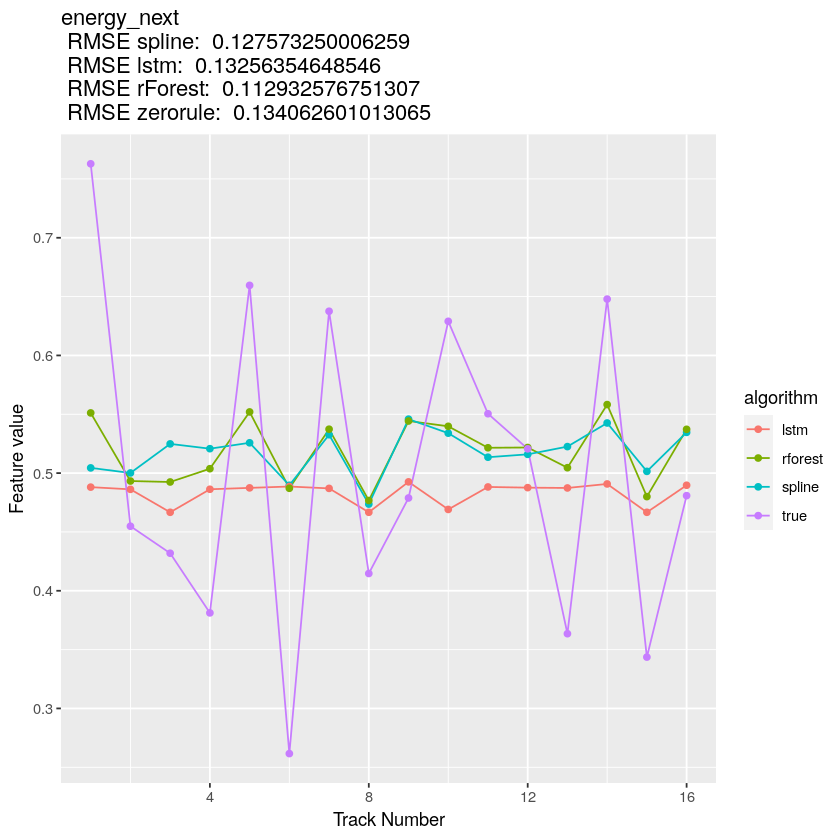

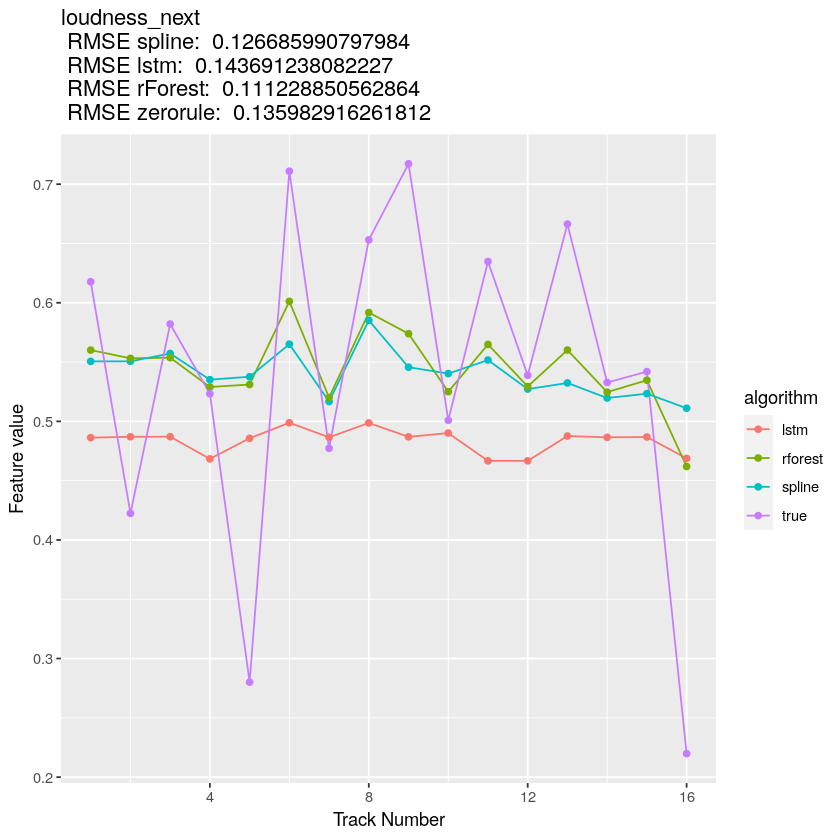

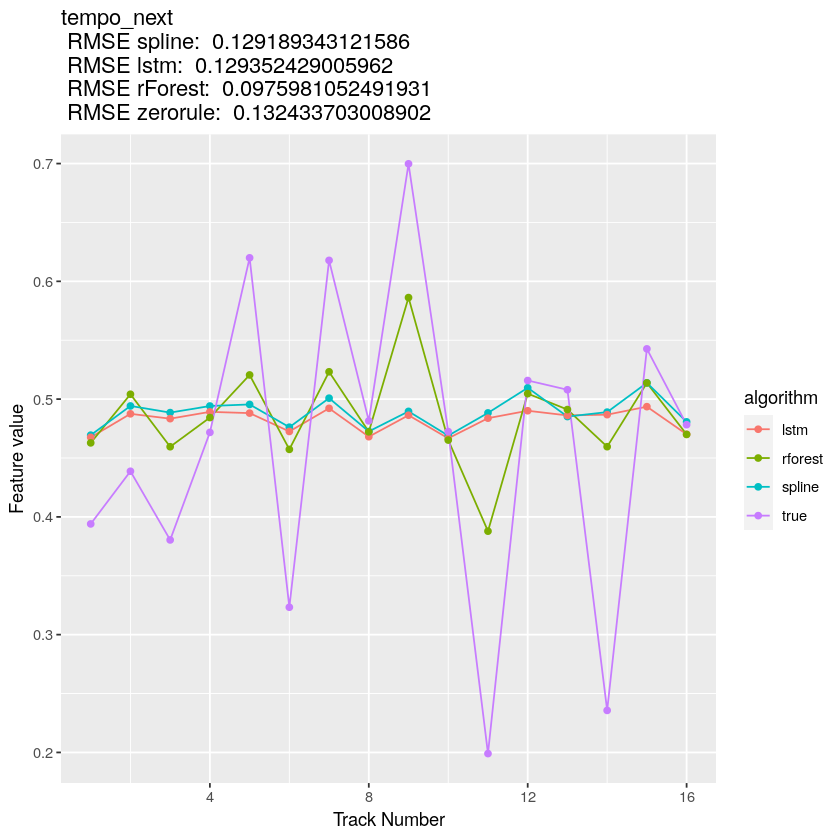

In [707]:
va; en; lo; te

## Accuracy versus RMSE

If we look at the predictions made by the random forest, we see that most of the predicted values are done in the correct direction. For instance, the last graph shows that, if the true valence of track in position $i+1$ is higher than that of the track in position $i$, the random forest algorithm also predicts feature in position $i+1$ to be higher than in position $i$. 

Perhaps I can compute an accuracy score, which says if the model guessed the next track in the right direction or 
not. With this evaluation strategy, the random forest model would become very accurate, since most of its mistakes appear to be related to the magnitude of the next feature.

## Possible issue

When we built these regressions models, we were trying to predict the feature of track $i+1$ given the feature(s) of track $i$. However, If we look at the pre-normalized distribution of say, loudness (below), we could hypothesize that, given an observed track (e.g. blue line), the loudness of the next track would, most likely, be higher than the current (e.g. red line). After z-score transformation, the distribution gets less skewed, and more like a gaussian curve. Still, this problem remains.

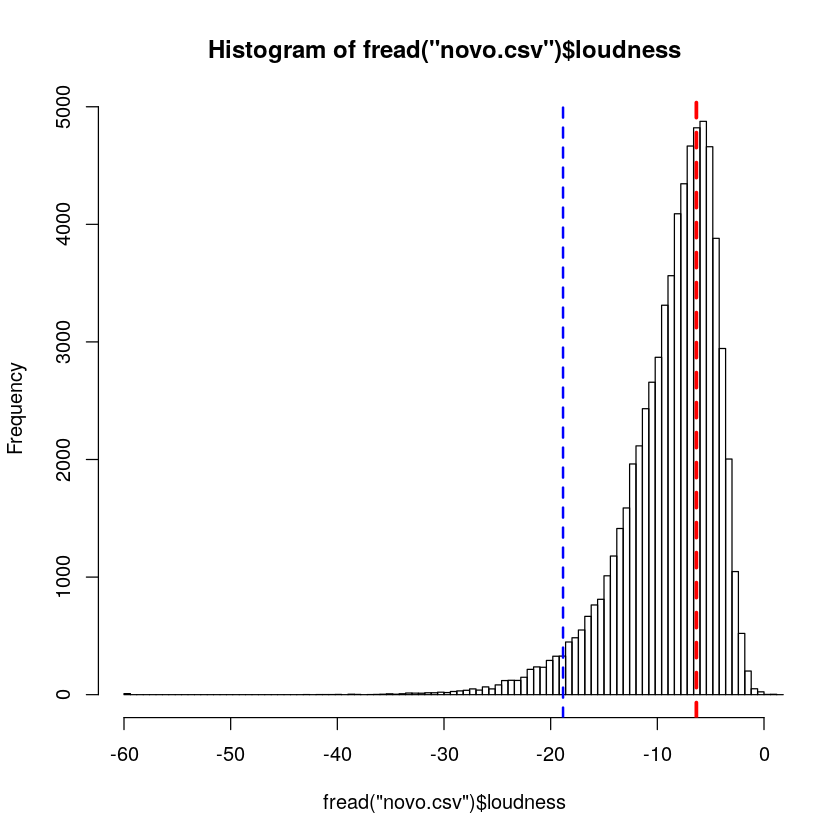

In [198]:
hist(fread("novo.csv")$loudness, xlim=c(-60, 0), breaks = seq(-60, 2, 0.6), )
abline(v = mean(fread("novo.csv")$loudness)+2.5, col="red", lwd=3, lty=2)
abline(v = mean(fread("novo.csv")$loudness)-10, col="blue", lwd=2, lty=2)

My point: If we use the current feature to predict the next feature, we might bias our models into going back to some central tendency measure, since values at the extreme of the distribution will most lileky be followed by more probable values (a kind of regression towards the mean effect). So I'm wondering if any of these regression results are informative to the questions that we're asking. 

If instead of asking "what is the feature of the next track?", we asked "where did they put this track in the album?" we could avoid this distributional bias. For instance, the musician could choose to always open an album with a track at the extreme right of the loudness distribution, and to close the album with a track at the extreme left.

In fact, if we try to categorize the position of a track, we're not explicitly looking for sequential effects. We are, however, trying to fit tracks into categories that correspont to a certain position in time (i.e. 1st, 2nd, 3d and 4th parts of the album).

In [703]:
# #I have also measured feature importance for the random forest algorithm. This measure represents the percentual increase of $MSE$ as a given predictor variable is randomly permutated. Results are displayed in the second graph.
# rf_imp = data.frame(
#         feature_importance = c(data.frame(importance(valence_rf))$X.IncMSE, 
#                                            data.frame(importance(energy_rf))$X.IncMSE, 
#                                            data.frame(importance(loudness_rf))$X.IncMSE, 
#                                            data.frame(importance(tempo_rf))$X.IncMSE),
#                 variable =   c(rownames(data.frame(valence_rf$importance)), 
#                                rownames(data.frame(energy_rf$importance)), 
#                                rownames(data.frame(loudness_rf$importance)), 
#                                rownames(data.frame(tempo_rf$importance))),
#                 predicted = c(rep("Next valence", 8), 
#                               rep("Next energy", 8), 
#                               rep("Next loudness", 8), 
#                               rep("Next tempo", 8))
#                    )


# rf_imp %>% 
#     ggplot(aes(x = reorder(variable, -feature_importance), y = feature_importance)) +
#     facet_wrap(~predicted)+
#     geom_segment(aes(xend = variable, yend = 20), size = 1, lineend = "butt", linetype = "dashed", col = "gray10") +
#     geom_point(size = 5, shape = 21, colour = "black", fill = "gray70", stroke = 2) +
#     geom_text(aes(label = round(feature_importance, digits = 1)), vjust = -1.25)+ylim(c(20, 80)) +
#     xlab("Predictor variable")+ylab("Feature importance (% of increase in MSE)")+ theme(axis.text.x = element_text(angle = 60))


## Proposed next steps 

I am also planning on:


- Tweaking the LSTM parameters to see if I can increase its accuracy;


- Training/testing the same models on the edges of the albums (i.e. 1st and last parts);


- (dissimilarity matrices) Perhaps we can find a way to include some of the dissimilarity matrix information in our regression models;


- (dissimilarity matrices - further ahear/brainstorming), we could think about treating each matrix as an image - again -, and training a deep learning model do generate new images (dissimilarity matrices) from a given seed (e.g. a list of album features).


- Try to improve the classification models.


